# Introduction to NLP at Karakun
## Part 3 - LSTM with Tensorflow

As an example task throughout this training we use a dataset for sentiment analysis. This dataset contains reviews from the movie plattform **IMDb**. These reviews are labeled as **positive** or **negative**. Our goal for the following tasks is to predict the sentiment of a given review.

Work through this notebook from top to bottom and execute the cells with code. A lot of the code is already prepared. Cells in this notebook which have to be completed with some code snippets are marked with: 

**<font color='red'>!! Call for action !!</font>**.

### Imports

In [2]:
import random
import nltk
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import pandas
import numpy as np
from collections import Counter
import itertools
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from   tensorflow import keras   

%matplotlib inline
%config InlineBackend.figure_format='retina'

# We set a random seed to have reproducible experiments
random.seed(0)

In [3]:
print(tf.__version__)

2.3.0


### Define data paths

In [4]:
# Train
train_pos_path = './Sentiment-Analysis-Data/imdb/train-pos.txt'
train_neg_path = './Sentiment-Analysis-Data/imdb/train-neg.txt'

# Test
test_pos_path = './Sentiment-Analysis-Data/imdb/test-pos.txt'
test_neg_path = './Sentiment-Analysis-Data/imdb/test-neg.txt'

### Prepare the data

Here we read the reviews from textfiles. All reviews are written into a list as a **tuple** together with their sentiment. This is the same procedure as in exercise 1.

In [5]:
def read_split_reviews_from_file(file_path, sentiment):
    reviews = []
    
    with open(file_path, 'r') as f:
        for line in f:
            # split text into single words and remove words with length smaller than 2
            review_splitted = [e.lower() for e in line.split() if len(e) >= 2]
            reviews.append((review_splitted, sentiment))
            
    return reviews

For Tensorflow we changed our string labels (`pos` and `neg`) to numbers: `0` for negative and `1` for positive.

In [6]:
# Train
train_reviews_pos = read_split_reviews_from_file(train_pos_path, 1)
train_reviews_neg = read_split_reviews_from_file(train_neg_path, 0)

# Test
test_reviews_pos = read_split_reviews_from_file(test_pos_path, 1)
test_reviews_neg = read_split_reviews_from_file(test_neg_path, 0)

In [7]:
# Concatenate positive and negative reviews
train_reviews = train_reviews_pos + train_reviews_neg
test_reviews = test_reviews_pos + test_reviews_neg

In [8]:
# Shuffle the train and test datasets
random.shuffle(train_reviews)
random.shuffle(test_reviews)

In [9]:
N_test= int(len(test_reviews)/2)

eval_reviews = test_reviews[:N_test]
test_reviews = test_reviews[N_test:]

In [10]:
# Check sizes of dataset
print(f'Train size:\t{len(train_reviews)} \nEval size:\t{len(eval_reviews)} \nTest size:\t{len(test_reviews)}')

Train size:	25000 
Eval size:	12500 
Test size:	12500


For the Tensorflow model we need to further split the tuples into input (`X`) and output (`y`) variables

In [18]:
train_X = [review for (review, sent) in train_reviews]
train_y = [sent for (review, sent) in train_reviews]

eval_X = [review for (review, sent) in eval_reviews]
eval_y = [sent for (review, sent) in eval_reviews]

test_X = [review for (review, sent) in test_reviews]
test_y = [sent for (review, sent) in test_reviews]

In [19]:
# Check single sample
INDEX = 230
print(f'> Input:\n================\n{train_X[INDEX]} \n\n> Output:\n================\n{train_y[INDEX]}')

> Input:
['judy', 'davis', 'shows', 'us', 'here', 'why', 'she', 'is', 'one', 'of', 'australia', 'most', 'respected', 'and', 'loved', 'actors', 'her', 'portrayal', 'of', 'lonely', 'directionless', 'nomad', 'is', 'first', 'rate', 'teenaged', 'claudia', 'karvan', 'also', 'gives', 'us', 'glimpse', 'of', 'what', 'would', 'make', 'her', 'one', 'of', 'this', 'country', 'most', 'popular', 'actors', 'in', 'years', 'to', 'come', 'with', 'future', 'roles', 'in', 'the', 'big', 'steal', 'the', 'heartbreak', 'kid', 'dating', 'the', 'enemy', 'risk', 'and', 'the', 'acclaimed', 'tv', 'series', 'the', 'secret', 'life', 'of', 'us', 'incidentally', 'karvan', 'as', 'child', 'was', 'young', 'girl', 'whose', 'toy', 'panda', 'was', 'stolen', 'outside', 'chemist', 'shop', 'in', 'the', 'drama', 'going', 'down', 'with', 'tracey', 'mann', 'if', 'this', 'films', 'comes', 'your', 'way', 'make', 'sure', 'you', 'see', 'it', 'rating', 'see', 'also', 'hotel', 'sorrento', 'radiance', 'vacant', 'possession', 'lantana'] 


Build a vocabulary with our training data.

In [20]:
vocab = defaultdict(lambda: 1)
vocab['<PAD>'] = 0

for idx in range(len(train_X)):
    for word in train_X[idx]:
        if word not in vocab: 
            vocab[word] = len(vocab)+1
            
print('The length of the vocabulary is: ', len(vocab))

vocab_size = len(vocab) + 1

The length of the vocabulary is:  73967


In [21]:
print(vocab['the'])
print(vocab['<PAD>'])
print(vocab['Karakun'])   # unknown token (not in dictionary)

19
0
1


Transform the word lists to integer lists:

In [22]:
for i in range(len(train_X)):
    train_X[i] = [vocab[word] for word in train_X[i]]

for i in range(len(eval_X)):
    eval_X[i] = [vocab[word] for word in eval_X[i]]
    
for i in range(len(test_X)):
    test_X[i] = [vocab[word] for word in test_X[i]]
    
print(train_X[:10])

[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 7, 9, 22, 23, 24, 25, 26, 27, 22, 28, 29, 30, 31, 32, 33, 22, 34, 35, 36, 19, 37, 14, 31, 38, 11, 39, 40, 26, 41, 14, 15, 16, 19, 42, 43, 44, 4, 45, 46, 14, 34, 47, 22, 48, 49, 50, 51, 52, 53, 54, 22, 48, 24, 51, 55, 16, 56, 57, 58, 59, 60, 4, 61, 7, 62, 63, 64, 62, 65, 66, 19, 14, 67, 22, 11, 68, 69, 28, 70, 71, 31, 22, 8, 72, 73, 16, 14, 34, 2, 74, 74, 75, 76, 46, 14, 77, 78, 79, 78, 75, 19, 6, 77, 80, 81, 82, 75, 22, 83, 84, 13, 85], [19, 86, 87, 88, 16, 89, 34, 90, 91, 92, 19, 93, 94, 19, 95, 96, 97, 98, 99, 100, 26, 49, 101, 19, 102, 71, 103, 104, 105, 106, 107, 108, 109, 110, 111, 50, 91, 112, 113, 104, 114, 19, 115, 116, 4, 109, 117, 109, 118, 109, 92, 119, 120, 121, 7, 122, 111, 123, 26, 124, 70, 4, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 111, 19, 136, 137, 26, 138, 126, 34, 139, 140, 22, 19, 141, 142, 143, 4, 80, 82, 144, 145, 111, 26, 70, 146, 147, 148, 4, 149, 150, 151, 78, 152, 153, 154

The dataset is now preprocessed: each example is an array of integers representing the words of the movie review.

Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

The text of reviews have been converted to integers, where each integer represents a specific word in a dictionary. Here's what the one review looks like:

In [23]:
# Check single sample after preprocessing
INDEX = 230
print(f'> Input:\n================\n{train_X[INDEX]} \n\n> Output (label):\n================\n{train_y[INDEX]}')

> Input:
[7722, 2035, 1325, 1405, 850, 38, 406, 34, 123, 4, 7723, 334, 4913, 7, 954, 495, 391, 2278, 4, 3751, 7724, 7725, 34, 377, 4938, 7726, 7727, 7728, 577, 1221, 1405, 4368, 4, 432, 11, 128, 391, 123, 4, 16, 1377, 334, 4898, 495, 111, 707, 26, 1329, 315, 658, 631, 111, 19, 2, 1647, 19, 7729, 621, 7730, 19, 1162, 1241, 7, 19, 4663, 426, 461, 19, 3476, 440, 4, 1405, 7731, 7728, 78, 3164, 222, 911, 501, 6467, 7732, 7733, 222, 5447, 2687, 7734, 7735, 111, 19, 384, 708, 261, 315, 7736, 7737, 161, 16, 354, 871, 470, 198, 128, 1651, 80, 124, 22, 331, 124, 577, 5106, 7738, 7739, 6288, 6336, 7740] 

> Output (label):
1


We can also reverse this transformation to get back text:

In [24]:
#reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
reverse_word_index = dict([(value, key) for (key, value) in vocab.items()])

#  Helper function to decode reviews:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [25]:
encoded_text = train_X[230][:6]

print(f'Encoded:\t{encoded_text}')

decoded_text = decode_review(encoded_text)

print(f'Decoded:\t{decoded_text}')

Encoded:	[7722, 2035, 1325, 1405, 850, 38]
Decoded:	judy davis shows us here why


### Prepare the data:

The reviews (arrays of integer) must be converted to tensors before fed into the neural network. <br>
This conversion can be done in two ways:

-  **One-hot-encode** of the arrays to convert them into vectors of 0s and 1s. <br> This approach is memory intensive, though, requiring a **num_words * num_reviews** size matrix. 


-  Alternatively, we can **pad the arrays** so they all have the same length, then create an integer tensor of shape **max_length * num_reviews**. We can use an embedding layer capable of handling this shape as the first layer in our network.

In this tutorial, we will use the second approach.

Since the movie reviews must be the same length, we will use the **pad_sequences** function to standardize the lengths:

In [26]:
print(vocab["<PAD>"])

0


In [27]:
train_X = keras.preprocessing.sequence.pad_sequences(train_X,
                                                        value=vocab["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

eval_X = keras.preprocessing.sequence.pad_sequences(eval_X,
                                                       value=vocab["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

test_X = keras.preprocessing.sequence.pad_sequences(test_X,
                                                       value=vocab["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

Check if this worked out:

In [28]:
INDEX = 230
print(train_X[INDEX])
print(decode_review(train_X[INDEX]))

[7722 2035 1325 1405  850   38  406   34  123    4 7723  334 4913    7
  954  495  391 2278    4 3751 7724 7725   34  377 4938 7726 7727 7728
  577 1221 1405 4368    4  432   11  128  391  123    4   16 1377  334
 4898  495  111  707   26 1329  315  658  631  111   19    2 1647   19
 7729  621 7730   19 1162 1241    7   19 4663  426  461   19 3476  440
    4 1405 7731 7728   78 3164  222  911  501 6467 7732 7733  222 5447
 2687 7734 7735  111   19  384  708  261  315 7736 7737  161   16  354
  871  470  198  128 1651   80  124   22  331  124  577 5106 7738 7739
 6288 6336 7740    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

### Build a first model:

The neural network is created by stacking layers — this requires two main architectural decisions:

-  How many layers to use in the model ?
-  How many hidden units to use for each layer ?

In this example, the input data consists of an array of word-indices. The labels to predict are either 0 or 1. <br> Let's build a model for this problem::

In [55]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(50, kernel_initializer='glorot_uniform', activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 32)          2366976   
_________________________________________________________________
dropout_18 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
global_average_pooling1d_9 ( (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 50)                1650      
_________________________________________________________________
dropout_19 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 51        
Total params: 2,368,677
Trainable params: 2,368,677
Non-trainable params: 0
____________________________________________

The layers are stacked sequentially to build the classifier:

1)  The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array.
<br> The resulting dimensions are: **(batch, sequence, embedding)**.

2)  Next, a **GlobalAveragePooling1D** layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model can handle input of variable length, in the simplest way possible.

3)  This fixed-length output vector is piped through a fully-connected (Dense) layer with 20 hidden units.

4)  The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. <br> 
Since this is a binary classification problem and the model outputs of a probability (sigmoid activation), we'll use the **binary_crossentropy** loss function.

Alternatively we could use **mean_squared_error**, but in general, binary_crossentropy is superior for probabilities — since it measures the "distance" between probability distributions (in our case between the ground-truth and the predictions).

Now, we configure the model to use an (Adam)optimizer and the (binary_crossentropy) loss function:

In [56]:
model.compile(optimizer=tf.optimizers.Adam() , loss='binary_crossentropy', metrics=['accuracy'])

### Train the model

We train the model for 40 epochs in mini-batches of 512 samples. <br>
This is 40 iterations over all samples in the **train_data** and **train_labels** tensors. <br>
While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [57]:
history = model.fit(np.array(train_X), np.array(train_y), epochs=30, batch_size=512, validation_data=(np.array(eval_X), np.array(eval_y) ) , verbose=1)

Epoch 1/30
49/49 [==============================] - 4s 80ms/step - loss: 0.6900 - accuracy: 0.5908 - val_loss: 0.6831 - val_accuracy: 0.6573
Epoch 2/30
49/49 [==============================] - 4s 73ms/step - loss: 0.6590 - accuracy: 0.7304 - val_loss: 0.6244 - val_accuracy: 0.7705
Epoch 3/30
49/49 [==============================] - 3s 71ms/step - loss: 0.5636 - accuracy: 0.7952 - val_loss: 0.5103 - val_accuracy: 0.8122
Epoch 4/30
49/49 [==============================] - 4s 74ms/step - loss: 0.4443 - accuracy: 0.8374 - val_loss: 0.4125 - val_accuracy: 0.8481
Epoch 5/30
49/49 [==============================] - 4s 73ms/step - loss: 0.3549 - accuracy: 0.8739 - val_loss: 0.3544 - val_accuracy: 0.8656
Epoch 6/30
49/49 [==============================] - 4s 76ms/step - loss: 0.2958 - accuracy: 0.8940 - val_loss: 0.3244 - val_accuracy: 0.8717
Epoch 7/30
49/49 [==============================] - 4s 75ms/step - loss: 0.2550 - accuracy: 0.9102 - val_loss: 0.3040 - val_accuracy: 0.8791
Epoch 8/30
49

#### Create a graph of accuracy and loss over time

**model.fit()** returns a history object that contains a dictionary with everything that happened during training:

In [58]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

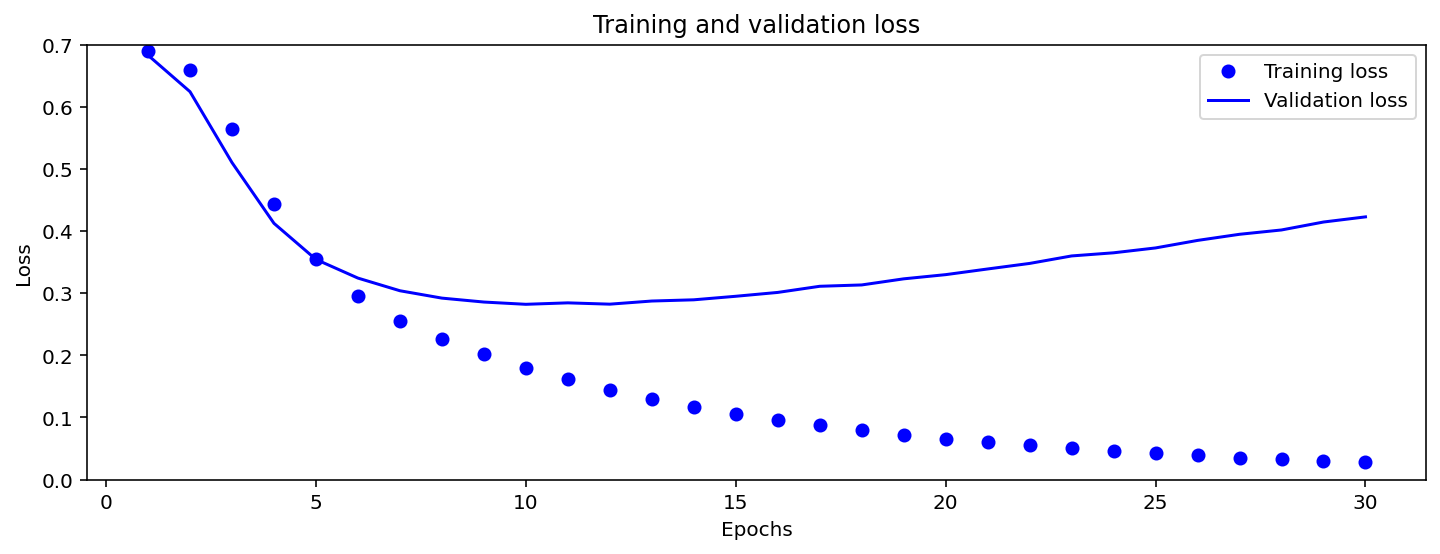

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.rcParams['figure.figsize'] = (12.0, 4.0)

epochs = range(1, len(acc) + 1)

plt.plot(epochs,     loss, 'bo', label='Training loss')      # "bo" is for "blue dot"
plt.plot(epochs, val_loss, 'b' , label='Validation loss')    # b is for "solid blue line"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
axes = plt.gca()
axes.set_ylim([0.0,0.7])

plt.show()

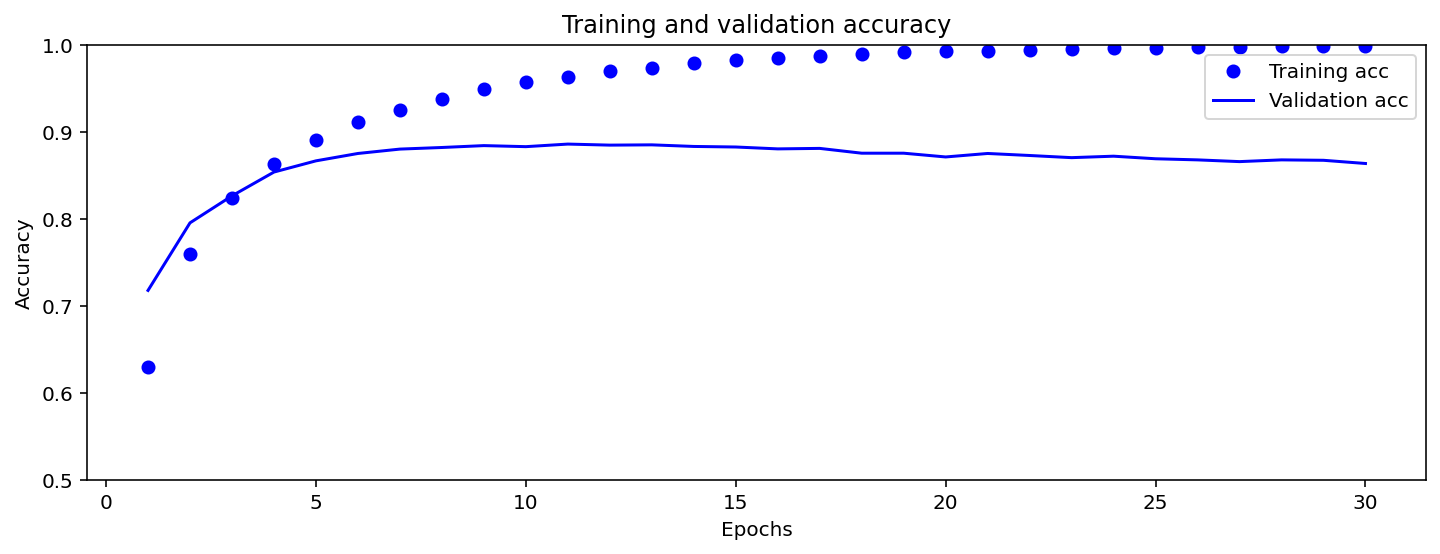

In [34]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs,     acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b' , label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

axes = plt.gca()
axes.set_ylim([0.5,1])

plt.show()

The training loss decreases monotonically, but the validation loss has a minimum around 10 epochs. <br>
This is an example of overfitting !

In this particular case, we could prevent overfitting with **early stopping** the training. 

In [60]:
results = model.evaluate(np.array(eval_X), np.array(eval_y))
print(results)

391/391 [==============================] - 0s 1ms/step - loss: 0.4229 - accuracy: 0.8687
[0.4228949248790741, 0.8687199950218201]


## <font color='red'>!! **Start** - Call for action !!</font>

We currently should be at a validation accuracy around **~0.864...**. Try to further improve by changing the cell were we defined our `Sequential` model. Try to add more layers, add dropout, change hyperparameters such as the embedding size and check if the model improves...

## <font color='red'>!! **End** - Call for action !!</font>

### Define some helper functions

Plot utility

In [61]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix'):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        txt = plt.text(j, i, "{:d}\n({:0.4f})".format(int(cm[i, j]), cm_normalized[i, j]),
                     horizontalalignment="center",
                     color="white")
            
        txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Check the performance on the test set

After improving our model with the help of the evaluation set we are now allowed to finally test our model with the testset.

In [62]:
results = model.evaluate(np.array(test_X), np.array(test_y))
print(results)

391/391 [==============================] - 0s 989us/step - loss: 0.4424 - accuracy: 0.8614
[0.4424179196357727, 0.8613600134849548]


In [63]:
test_gold = np.array(test_y)
predictions_test = np.array(model.predict(np.array(test_X)).ravel() >= 0.5, dtype=int)

cm_test = np.array(tf.math.confusion_matrix(test_gold, predictions_test))

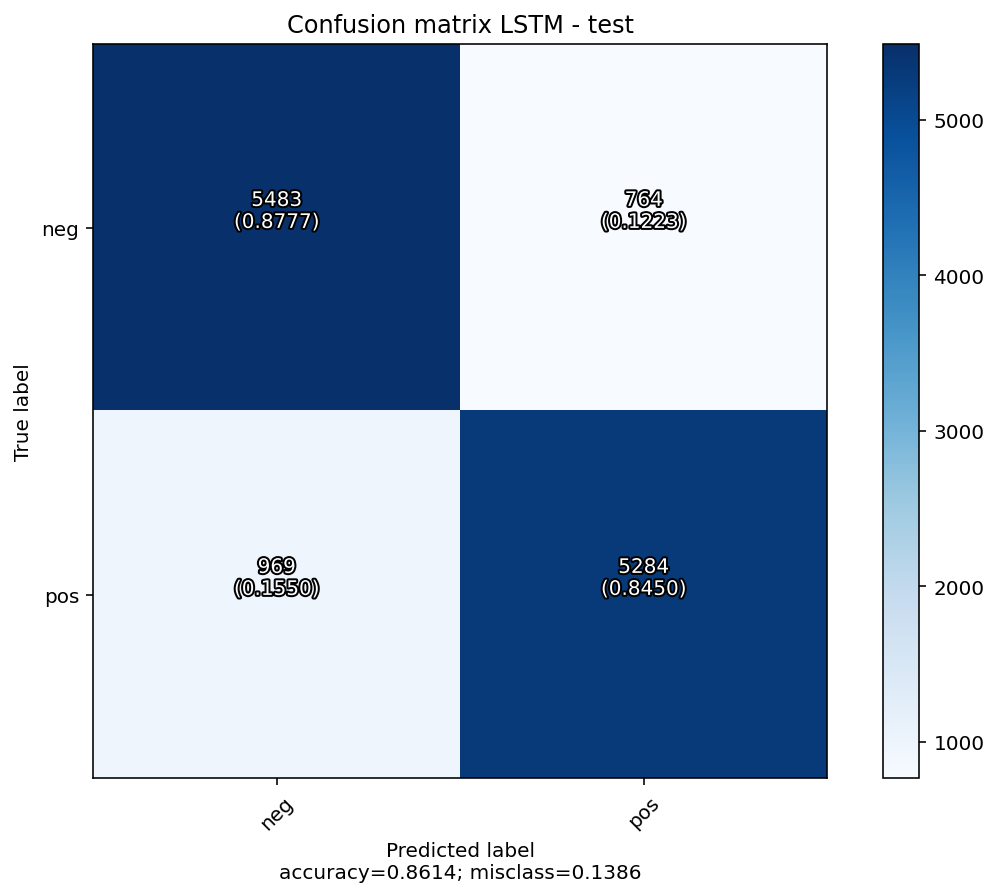

In [64]:
plot_confusion_matrix(cm_test, ['neg', 'pos'], title='Confusion matrix LSTM - test')